In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy import signal
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
#Defining Machine parameters 
mach_mc = {"rs": 0.1729, "lq": 0.6986, "ld": 0.4347, "tmech":50.0, "psi_rm":0.9}
# mach_mc = {"rs": 0.009, "ld": 4.14, "lq": 4.21, "tmech":509.6, "psi_rm": 0.5}

# mach_mb = {"rs": 0.0185, "rr": 0.0132, "lh": 3.81, "ls": 3.9, "lr": 3.9, "tmech":397.31}

# mach_ma = {"rs": 0.015, "rr": 0.04, "lh": 2.31, "ls": 2.35, "lr": 2.35, "tmech":596.9}

# mach_BM = {"rs": 0.0426, "rr": 0.02113, "lh": 2.252, "ls": 2.252+0.078, "lr": 2.252+0.1052, "tmech":200.}

###  The Machine Parameters
We use machine dictionaries to calculate the various parameters used in space vector based machine model This function is called mach_para(dict)

In [3]:
def mach_para(mach):
    """Takes in the dictionary containing machine parameters (normalized)
       and returns various parameters that are used in space vector equations
       
       Takes arguement: machine dictionary
       """
    rs = mach["rs"]
    ld = mach['ld']
    lq = mach['lq']
#     ws = mach['ws']
#     sig= 1-(lh*lh)/(lr*ls)
#     kr=lh/lr
#     sigls=sig*ls
#     tr=lr/rr
#     rk=(rs+(kr)*(kr)*rr)
#     tk=sigls/(rs+(kr)*(kr)*rr)
    tmech = mach['tmech']
    psi_rm = mach['psi_rm']
#     print("lh = {0:1.3f}".format(lh))
#     return rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech
    return rs, ld, lq, tmech, psi_rm

In [4]:
mach_para(mach_mc)

(0.1729, 0.4347, 0.6986, 50.0, 0.9)

### PMSM Dynamics
#### Building the Dynamic Model of a PMSM in the d-q Coordinate
To model a PMSM, two state variables are chosen, which are $i_{s}$ and $\omega_{s}$. The $i_{s}$ can be further decomposed to $i_{sd}$, $i_{sq}$ in the permanant magnetic field since it is a complex space vector. The differential equations of these vectors are given as:

\begin{align}
\frac{di_{sd}}{d\tau}&= -\frac{r_{s}}{l_{d}}i_{sd} + \omega_{s} \frac{l_q}{l_d}i_{sq} + \frac{v_{sd}}{l_d}\\
\frac{di_{sq}}{d\tau}&= - \omega_{s} \frac{l_d}{l_q}i_{sd} -\frac{r_{s}}{l_{q}}i_{sq}  - \omega_{s} \frac{\psi_{r,m}}{l_q} + \frac{v_{sq}}{l_q}\\
\frac{d\omega_s}{d\tau}&= \frac{1}{\tau_{mech}}\left[m_e - m_L\right], m_e = \psi_{r,m}i_{sq}+(l_d-l_q)i_{sd}i_{sq}
\end{align}


In [5]:
#Induction machine 5x5 dynamic model 

def IM_dynstep(X,t,params):
    """Defines a function to calculate the derivatives for a 5x5 Induction motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ and rotor flux space vector $\vec{\psi}_r$.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0] #isd
    x1 = X[1] #isq
    ws = X[2] # w
#     x2 = X[2]  #psiralpha
#     x3 = X[3]  #psirbeta
#     x4 = X[4]  #w
#     wx = X[5]
#     u1,u2,m_l,w_s,psi_rm, l_d, l_q = params
    u1,u2,m_l,w_s = params
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     print("u1:")
#     print(u1)
    
    A,B,C,D,tm = mach_imstep(mach_mc, params)
#     print("B[0]:")
#     print(B[0])
    m_diff = (psi_rm*x0+(l_d-l_q)*x0*x1) - m_l
    dx0_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[0][0]*u1)
    dx1_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[1][0]*(-w_s*psi_rm+u2))
    dx2_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[2][0]*m_diff)
#     print(A[1][0],A[1][1],A[1][2],A[1][3],B[4][0])
#     dx0dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*x2 + A[0][3]*x3*x4 + A[0][4]*x4 + B[0][0]*u1)
#     dx1dt = (A[1][0]*x0 + A[1][1]*x1 + A[1][2]*x2*x4 + A[1][3]*x3 + A[1][4]*x4 + B[1][0]*u2)
#     dx4dt = (A[4][0]*x0 + A[4][1]*x1 + A[4][2]*x2 + A[4][3]*x3 + A[4][4]*x4 + B[4][0]*mdiff)
#     dx2dt = (A[2][0]*x0 + A[2][1]*x1 + A[2][2]*x2 + A[2][3]*x3*x4 + A[2][4]*x4 + 0)
#     dx3dt = (A[3][0]*x0 + A[3][1]*x1 + A[3][2]*x2*x4 + A[3][3]*x3 + A[3][4]*x4 + 0)
#     dx4dt = (A[4][0]*x0 + A[4][1]*x1 + A[4][2]*x2 + A[4][3]*x3 + A[4][4]*x4 + B[4][0]*mdiff)
#     dwxdt = rate
    return [dx0_dt,dx1_dt,dx2_dt]


def mach_imstep(mc_dict, params):
    """
    Define the induction model that is a 3x3 matrix. 
    1. The current components are $i_s\alpha + ji_{s \beta}$. 
    2. The rotor flux components are $\psi_{s\alpha} + j\psi_{s\beta}$ and $\omega$
    3. Needs machine dictionary as input
    4. does not use $\omega_s$ in this function, it will be multipied in the derivative function
    """
    u1,u2,m_l,ws = params
#     rs,rr,ld,lq,sig,kr,tr,rk,tk,tmech = mach_para(mc_dict)
    rs,ld,lq, tmech, psi_rm = mach_para(mc_dict)
    a11 = -(rs/ld)
    a12 = ((ws*lq)/ld)
    a13 = 0
#     a14 = (kr/(sig*ls))   #has to be multiplied by omega
#     a15 = 0


    a21 = -((ld*ws)/lq)
    a22 = -rs/lq
    a23 = 0
#     a24 = a13
#     a25 = 0

    a31 = 0
    a32 = 0 
    a33 = 0

    b11 = 1/(ld)
    b21 = 1/(lq)
    b31 = 1/(tmech)
#     b41 = 0
#     b51 = 1/(tmech)
    

    c11 = 1.0
    c22 = 1.0
    c33 = 1.0
#     c44 = 1.0
#     c55 = 1.0

    A = ([a11,a12,a13],[a21,a22,a23],[a31,a32,a33])
    B = ([b11], [b21], [b31])
    C = ([c11, c22, c33])
    D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     C=([c11,0,0],[0,c22,0],[0,0,c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     A=([a11,a12,a13,a14,a15],[a21,a22,a23,a24,a25],[a31,a32,a33,a34,a35],[a41,a42,a43,a44,a45,[a51,a52,a53,a54,a55])
#     B=([b11,0],[b21,0],[b31,0],[b41,0],[b51,0])
#     C=([c11,0,0,0,0],[0,c22,0,0,0],[0,0,c33,0,0],[0,0,0,c44,0],[0,0,0,0,a55])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
    
    return A, B, C, D, tmech

In [6]:
#Rotor dynamics as mechanics
def rotor_dyndq(X,t,params):
    w = X[0]
    gamma = X[1] #rotor angle
    
    me,mL,tmech = params
    dwdt = (me-mL)/tmech
    dgammadt = w
    return [dwdt, dgammadt]
    

In [7]:
#Function for rotor angle integration 
# d\delta/dt = w

def rotorangle(X,t,params):
    del0 = X
    w = params
    ddel0dt = w
    return ddel0dt

In [8]:
def PIcon(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
    return y2

def PIconwithLim(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti, uplim, dwnlim = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
#     y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    yx = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
    if (yx > uplim):
        yx = uplim
    elif (yx < dwnlim):
        yx = dwnlim
    y2 = yx
    return y2

## 1. System Dynamics without Control

## 2. System Dynamics with Control

## 3. System with Increasing Speed $\omega_s$

In [9]:
#Induction machine 5x5 dynamic model 

def PMSM_dynStep2By2(X,t,params):
    """Defines a function to calculate the derivatives for a 5x5 Induction motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ and rotor flux space vector $\vec{\psi}_r$.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0] #isd
    x1 = X[1] #isq
#     x2 = X[2]  #psiralpha
#     x3 = X[3]  #psirbeta
#     x4 = X[4]  #w
#     wx = X[5]
#     u1,u2,m_l,w_s,psi_rm, l_d, l_q = params
    u1,u2,m_l,w_s = params
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     print("u1:")
#     print(u1)
    
    A,B,C,D,tm = mach_PMSMStep2By2(mach_mc, params)
#     print("B[0]:")
#     print(B[0])
    m_diff = (psi_rm*x0+(l_d-l_q)*x0*x1) - m_l
    dx0_dt = (A[0][0]*x0 + A[0][1]*x1 + B[0][0]*u1)
    dx1_dt = (A[0][0]*x0 + A[0][1]*x1+ B[1][0]*(-w_s*psi_rm+u2))
#     dx2_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[2][0]*m_diff)

    return [dx0_dt,dx1_dt]


def mach_PMSMStep2By2(mc_dict, params):
    """
    Define the induction model that is a 3x3 matrix. 
    1. The current components are $i_s\alpha + ji_{s \beta}$. 
    2. The rotor flux components are $\psi_{s\alpha} + j\psi_{s\beta}$ and $\omega$
    3. Needs machine dictionary as input
    4. does not use $\omega_s$ in this function, it will be multipied in the derivative function
    """
    u1,u2,m_l,ws = params
#     rs,rr,ld,lq,sig,kr,tr,rk,tk,tmech = mach_para(mc_dict)
    rs,ld,lq, tmech, psi_rm = mach_para(mc_dict)
    a11 = -(rs/ld)
    a12 = ((ws*lq)/ld)
#     a13 = 0
#     a14 = (kr/(sig*ls))   #has to be multiplied by omega
#     a15 = 0


    a21 = -((ld*ws)/lq)
    a22 = -rs/lq
#     a23 = 0
#     a24 = a13
#     a25 = 0

    a31 = 0
    a32 = 0 
#     a33 = 0

    b11 = 1/(ld)
    b21 = 1/(lq)
#     b31 = 1/(tmech)
#     b41 = 0
#     b51 = 1/(tmech)
    

    c11 = 1.0
    c22 = 1.0
#     c33 = 1.0
#     c44 = 1.0
#     c55 = 1.0
    A = ([a11,a12],[a21,a22],[a31,a32])
    B = ([b11], [b21])
    C = ([c11, c22])
    D= ([0,0],[0,0])
#     A = ([a11,a12,a13],[a21,a22,a23],[a31,a32,a33])
#     B = ([b11], [b21], [b31])
#     C = ([c11, c22, c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     C=([c11,0,0],[0,c22,0],[0,0,c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     A=([a11,a12,a13,a14,a15],[a21,a22,a23,a24,a25],[a31,a32,a33,a34,a35],[a41,a42,a43,a44,a45,[a51,a52,a53,a54,a55])
#     B=([b11,0],[b21,0],[b31,0],[b41,0],[b51,0])
#     C=([c11,0,0,0,0],[0,c22,0,0,0],[0,0,c33,0,0],[0,0,0,c44,0],[0,0,0,0,a55])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
    
    return A, B, C, D, tmech

In [10]:
#Rotor dynamics as mechanics
def rotor_dyndq(X,t,params):
    w = X[0]
    gamma = X[1] #rotor angle
    
    me,mL,tmech = params
    dwdt = (me-mL)/tmech
    dgammadt = w
    return [dwdt, dgammadt]

    if w < -zeroThresh:
        # a > 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = 0.85
            isq = -1
        else:
            isd = -0.85
            isq = -1
    else:
        # a < 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = -0.85
            isq = -1
        else:
            isd = 0.85
            isq = -1

In [18]:
zeroThresh = 0.0005
def calculateIsdIsqRefsBySpeedSimple(w, isSlowingDown):
    isd, isq = 0.0, 0.0
    a = 0.002
    ml = 0.0
    if w < -zeroThresh:
        # a > 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = 0.2
            isq = 0.105
        else:
            isd = 0.5
            isq = -0.09
    else:
        # a < 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = 0.5
            isq = -0.09
        else:
            isd = 0.2
            isq = 0.105
#     else:
#         isd, isq = 0.0, 0.0
#     if isSlowingDown < 0:
#         # slowing down:
#         isd = 0.5
#         isq = -0.09
#     else:
#         # speeding up
#         isd = 0.2
#         isq = 0.105
    print("calculate isd, isq:")
    print(isd, isq)
    return isd, isq
        

In [19]:
def braking(w, isSlowingDown):
    print("in braking")
    print(w)
    isd, isq = 0.0, 0.0
    if(abs(w) <= zeroThresh):
        isd, isq = 0.0, 0.0
    else:
        isd, isq = calculateIsdIsqRefsBySpeedSimple(w, 1)
    print("braking: isd, isq:")
    print(isd, isq)
    return isd, isq

In [20]:
def simulateSpeedingUpWithAcceleration():
    #Setting up the simulaton for rotor model
    # We will use for loop for simulation 
    rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
    tend = 20*3*np.pi
    tstart = 0.0
    delta_t = 0.01
    Tta = np.arange(tstart, tend,delta_t)
    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-3
    
    n = 100000
#     n2 = int(100*2*np.pi/0.01)
    # ws = -0.5
    ws = -0.5
    # Initializing ws:
#     a = 0.0001 # angular acceleration
#     for i in range(1, len(Tta)):
#         new_ws = ws[i-1]+a
#         if(new_ws > 1):
#             ws[i] = 1
#         else:
#             ws[i] = new_ws
    mL = 0.0
    # Tta = np.linspace(tstart, tend, n2)
    #delta_t = Tta[1] - Tta[0]
    usd = np.zeros(len(Tta))
    usq = np.zeros(len(Tta))
    sol1 = np.zeros((len(Tta),2))
    sol2 = np.zeros((len(Tta),2))
    FCangle = np.zeros(len(Tta))
    gamma = np.zeros(len(Tta)) # rotor angle
    # Field coordinate currents
    cosdelta = np.zeros(len(Tta))
    sindelta = np.zeros(len(Tta))
    isd = np.zeros(len(Tta))
    isq = np.zeros(len(Tta))
    eid = np.zeros(len(Tta))
    eiq = np.zeros(len(Tta))
    w = np.zeros(len(Tta))

    me = np.zeros(len(Tta))
    x0 = [0,0] # isd, isq, ws
    y0 = [0,0] # w, angle

    kpd = ld*1
    Tid = 25.0e1

    kpq = lq*2
    Tiq = 25.0e1

    Kparamsd = [kpd,Tid]
    Kparamsq = [kpq,Tiq]
    flag = 0

#     for ii in range(0, len(Tta))
    ii =0
    isdref = 0.0
    isqref = 0.0
    isdrefs = [isdref]
    isqrefs = [isqref]
    endOfStablization = 0
    while(ii < len(Tta)):      
        #Start controller after first step
        if ii>=0:
            eid[ii] = isdref - isd[ii-1]
            PIed = [eid[ii],eid[ii-1]]
            usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
            eiq[ii] = isqref - isq[ii-1]
            PIeq = [eiq[ii],eiq[ii-1]]
            usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)

        # solve for the state variables: isd, isq
        params = [usd[ii], usq[ii],w[ii], ws]
        sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
        sol1[ii]= sol1a[-1]
        x0 = sol1a[-1]
        isd[ii] = sol1[ii][0]
        isq[ii] = sol1[ii][1]
        # solve for w:
        me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
        paramsw = [me[ii],0.0,tmech]
        sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
        y0 = sol2a[-1]
        sol2[ii] = sol2a[-1]
        FCangle[ii] = sol2[ii][1]
        gamma[ii] = sol2[ii][1]
        w[ii] = sol2[ii][0]
#         TtaEnd = Tta[ii]
        print("w[ii]:")
        print(ii, Tta[ii], w[ii])
#         while(flag == 0 and ii+1 < len(Tta) and abs(w[ii]) > zeroThresh):
#             print("stablize the speed")
#             ii+=1
#             #Start controller after first step
#             if ii>=0:
#                 eid[ii] = isdref - isd[ii-1]
#                 PIed = [eid[ii],eid[ii-1]]
#                 usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
#                 eiq[ii] = isqref - isq[ii-1]
#                 PIeq = [eiq[ii],eiq[ii-1]]
#                 usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)
#             # solve for the state variables: isd, isq
#             params = [usd[ii], usq[ii],w[ii], ws]
#             sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
#             sol1[ii]= sol1a[-1]
#             x0 = sol1a[-1]
#             isd[ii] = sol1[ii][0]
#             isq[ii] = sol1[ii][1]
#             # solve for w:
#             me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
#             paramsw = [me[ii],0.0,tmech]
#             sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
#             y0 = sol2a[-1]
#             sol2[ii] = sol2a[-1]
#             FCangle[ii] = sol2[ii][1]
#             gamma[ii] = sol2[ii][1]
#             w[ii] = sol2[ii][0]
#             TtaEnd = Tta[ii]
            
#             print("w[ii]:")
#             print(ii, Tta[ii],w[ii])
#             # update isd isq:
# #             if(w[ii-1] > ):
#             isdref = 1
#             isqref = -0.35
#             isdrefs.append(isdref)
#             isqrefs.append(isqref)
#             if(Tta[ii] > 2*np.pi):
#                 flag = 1
#                 break
#             endOfStablization = ii
        print("New")
        if(ii < len(Tta) and Tta[ii] >= 2*np.pi and Tta[ii] < 20*np.pi):
            print("Speeding up from:")
            print(Tta[ii])
            isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 0)
            isdrefs.append(isdref)
            isqrefs.append(isqref)
        elif(ii < len(Tta) and Tta[ii] >= 20*np.pi and Tta[ii] < 30*np.pi):
            print("Uniform speed from:")
            print(Tta[ii])
            isdref = 0
            isqref = 0
            isdrefs.append(isdref)
            isqrefs.append(isqref)
        else:
            print("Before Braking: w:")
            print(w[ii])
            print(Tta[ii])
            isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 1)
            isdrefs.append(isdref)
            isqrefs.append(isqref)
        ii += 1
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     me = psi_rm*isq + (l_d-l_q)*isd*isq # get torque
    return Tta, w, me, isd, isq, np.array(isdrefs)[0:len(Tta)], np.array(isqrefs)[0:len(Tta)]

In [21]:
# import matplotlib.pyplot as pl
# %matplotlib inline
def plotDynamicForSpeedingUp(Tta, w1, me1, isd1, isq1, isdref, isqref):
    pl.figure(531, figsize = (6,6))
    pl.rc('font', size = 16)
    # plot the isd and isq
    pl.subplot(2,1,1)
    pl.plot(Tta,  isd, 'purple', Tta, isdref,'skyblue', lw=3)
    pl.plot(Tta, isqref,'tomato', Tta,isq ,'crimson' ,lw =2)

    pl.xlim(0,Tta[-1])
    pl.ylabel(r'$isd, isq$' )
    pl.xticks(np.linspace(0,Tta[-1],5))

    ax1 = pl.subplot(2,1,2)
    ax1.axhline(0)
    ax1.plot(Tta, me1, 'crimson', lw =2)
    ax1.set_yticks(np.linspace(-1.0,1.0,5))
    ax1.set_ylabel('me [p.u]')
    ax2 = ax1.twinx()
    ax2.set_ylabel('$\omega$')
    ax2.plot(Tta,w, 'peru', lw =3)

w[ii]:
0 0.0 1.2831457301089506e-06
New
Before Braking: w:
1.2831457301089506e-06
0.0
calculate isd, isq:
0.5 -0.09
w[ii]:
1 0.01 3.4487364771790176e-06
New
Before Braking: w:
3.4487364771790176e-06
0.01
calculate isd, isq:
0.5 -0.09
w[ii]:
2 0.02 6.464466396196482e-06
New
Before Braking: w:
6.464466396196482e-06
0.02
calculate isd, isq:
0.5 -0.09
w[ii]:
3 0.03 1.029898711753588e-05
New
Before Braking: w:
1.029898711753588e-05
0.03
calculate isd, isq:
0.5 -0.09
w[ii]:
4 0.04 1.4921921296415881e-05
New
Before Braking: w:
1.4921921296415881e-05
0.04
calculate isd, isq:
0.5 -0.09
w[ii]:
5 0.05 2.0303833041626293e-05
New
Before Braking: w:
2.0303833041626293e-05
0.05
calculate isd, isq:
0.5 -0.09
w[ii]:
6 0.06 2.641619845422877e-05
New
Before Braking: w:
2.641619845422877e-05
0.06
calculate isd, isq:
0.5 -0.09
w[ii]:
7 0.07 3.323137689484074e-05
New
Before Braking: w:
3.323137689484074e-05
0.07
calculate isd, isq:
0.5 -0.09
w[ii]:
8 0.08 4.072258308028152e-05
New
Before Braking: w:
4.07225

New
Before Braking: w:
0.0026113227015133623
3.8000000000000003
calculate isd, isq:
0.5 -0.09
w[ii]:
381 3.81 0.0026050080631373857
New
Before Braking: w:
0.0026050080631373857
3.81
calculate isd, isq:
0.5 -0.09
w[ii]:
382 3.8200000000000003 0.0025986534561040654
New
Before Braking: w:
0.0025986534561040654
3.8200000000000003
calculate isd, isq:
0.5 -0.09
w[ii]:
383 3.83 0.002592259095470492
New
Before Braking: w:
0.002592259095470492
3.83
calculate isd, isq:
0.5 -0.09
w[ii]:
384 3.84 0.002585825195107717
New
Before Braking: w:
0.002585825195107717
3.84
calculate isd, isq:
0.5 -0.09
w[ii]:
385 3.85 0.0025793519677062915
New
Before Braking: w:
0.0025793519677062915
3.85
calculate isd, isq:
0.5 -0.09
w[ii]:
386 3.86 0.0025728396247818065
New
Before Braking: w:
0.0025728396247818065
3.86
calculate isd, isq:
0.5 -0.09
w[ii]:
387 3.87 0.0025662883766804073
New
Before Braking: w:
0.0025662883766804073
3.87
calculate isd, isq:
0.5 -0.09
w[ii]:
388 3.88 0.0025596984325843156
New
Before Braking

595 5.95 0.0006011637707581149
New
Before Braking: w:
0.0006011637707581149
5.95
calculate isd, isq:
0.5 -0.09
w[ii]:
596 5.96 0.0005896908770853049
New
Before Braking: w:
0.0005896908770853049
5.96
calculate isd, isq:
0.5 -0.09
w[ii]:
597 5.97 0.0005782046813218086
New
Before Braking: w:
0.0005782046813218086
5.97
calculate isd, isq:
0.5 -0.09
w[ii]:
598 5.98 0.0005667052451322476
New
Before Braking: w:
0.0005667052451322476
5.98
calculate isd, isq:
0.5 -0.09
w[ii]:
599 5.99 0.0005551926298169359
New
Before Braking: w:
0.0005551926298169359
5.99
calculate isd, isq:
0.5 -0.09
w[ii]:
600 6.0 0.0005436668963140607
New
Before Braking: w:
0.0005436668963140607
6.0
calculate isd, isq:
0.5 -0.09
w[ii]:
601 6.01 0.0005321281052018574
New
Before Braking: w:
0.0005321281052018574
6.01
calculate isd, isq:
0.5 -0.09
w[ii]:
602 6.0200000000000005 0.0005205763167007672
New
Before Braking: w:
0.0005205763167007672
6.0200000000000005
calculate isd, isq:
0.5 -0.09
w[ii]:
603 6.03 0.0005090115906755876

0.2 0.105
w[ii]:
1042 10.42 0.008468883899873363
New
Speeding up from:
10.42
calculate isd, isq:
0.2 0.105
w[ii]:
1043 10.43 0.008492476053471261
New
Speeding up from:
10.43
calculate isd, isq:
0.2 0.105
w[ii]:
1044 10.44 0.008516053914161537
New
Speeding up from:
10.44
calculate isd, isq:
0.2 0.105
w[ii]:
1045 10.450000000000001 0.008539617487421035
New
Speeding up from:
10.450000000000001
calculate isd, isq:
0.2 0.105
w[ii]:
1046 10.46 0.008563166779340329
New
Speeding up from:
10.46
calculate isd, isq:
0.2 0.105
w[ii]:
1047 10.47 0.008586701796615692
New
Speeding up from:
10.47
calculate isd, isq:
0.2 0.105
w[ii]:
1048 10.48 0.008610222546541209
New
Speeding up from:
10.48
calculate isd, isq:
0.2 0.105
w[ii]:
1049 10.49 0.008633729037000883
New
Speeding up from:
10.49
calculate isd, isq:
0.2 0.105
w[ii]:
1050 10.5 0.008657221276460868
New
Speeding up from:
10.5
calculate isd, isq:
0.2 0.105
w[ii]:
1051 10.51 0.008680699273961763
New
Speeding up from:
10.51
calculate isd, isq:
0.2 0.

Speeding up from:
12.59
calculate isd, isq:
0.2 0.105
w[ii]:
1260 12.6 0.01331612769569784
New
Speeding up from:
12.6
calculate isd, isq:
0.2 0.105
w[ii]:
1261 12.61 0.013337265817728105
New
Speeding up from:
12.61
calculate isd, isq:
0.2 0.105
w[ii]:
1262 12.620000000000001 0.013358396619236997
New
Speeding up from:
12.620000000000001
calculate isd, isq:
0.2 0.105
w[ii]:
1263 12.63 0.01337952013488296
New
Speeding up from:
12.63
calculate isd, isq:
0.2 0.105
w[ii]:
1264 12.64 0.013400636399235995
New
Speeding up from:
12.64
calculate isd, isq:
0.2 0.105
w[ii]:
1265 12.65 0.013421745446777118
New
Speeding up from:
12.65
calculate isd, isq:
0.2 0.105
w[ii]:
1266 12.66 0.013442847311897814
New
Speeding up from:
12.66
calculate isd, isq:
0.2 0.105
w[ii]:
1267 12.67 0.013463942028899528
New
Speeding up from:
12.67
calculate isd, isq:
0.2 0.105
w[ii]:
1268 12.68 0.013485029631993151
New
Speeding up from:
12.68
calculate isd, isq:
0.2 0.105
w[ii]:
1269 12.69 0.01350611015529853
New
Speeding 

Speeding up from:
17.41
calculate isd, isq:
0.2 0.105
w[ii]:
1742 17.42 0.023088350123870133
New
Speeding up from:
17.42
calculate isd, isq:
0.2 0.105
w[ii]:
1743 17.43 0.023108289451656452
New
Speeding up from:
17.43
calculate isd, isq:
0.2 0.105
w[ii]:
1744 17.44 0.02312822848586705
New
Speeding up from:
17.44
calculate isd, isq:
0.2 0.105
w[ii]:
1745 17.45 0.023148167228949607
New
Speeding up from:
17.45
calculate isd, isq:
0.2 0.105
w[ii]:
1746 17.46 0.023168105683332607
New
Speeding up from:
17.46
calculate isd, isq:
0.2 0.105
w[ii]:
1747 17.47 0.023188043851425463
New
Speeding up from:
17.47
calculate isd, isq:
0.2 0.105
w[ii]:
1748 17.48 0.023207981735618645
New
Speeding up from:
17.48
calculate isd, isq:
0.2 0.105
w[ii]:
1749 17.490000000000002 0.02322791933828381
New
Speeding up from:
17.490000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
1750 17.5 0.023247856661773945
New
Speeding up from:
17.5
calculate isd, isq:
0.2 0.105
w[ii]:
1751 17.51 0.023267793708423492
New
Speeding

2170 21.7 0.03161139954776054
New
Speeding up from:
21.7
calculate isd, isq:
0.2 0.105
w[ii]:
2171 21.71 0.03163130359741301
New
Speeding up from:
21.71
calculate isd, isq:
0.2 0.105
w[ii]:
2172 21.72 0.03165120762748517
New
Speeding up from:
21.72
calculate isd, isq:
0.2 0.105
w[ii]:
2173 21.73 0.03167111163800529
New
Speeding up from:
21.73
calculate isd, isq:
0.2 0.105
w[ii]:
2174 21.740000000000002 0.031691015629001285
New
Speeding up from:
21.740000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
2175 21.75 0.03171091960050072
New
Speeding up from:
21.75
calculate isd, isq:
0.2 0.105
w[ii]:
2176 21.76 0.031730823552530846
New
Speeding up from:
21.76
calculate isd, isq:
0.2 0.105
w[ii]:
2177 21.77 0.03175072748511857
New
Speeding up from:
21.77
calculate isd, isq:
0.2 0.105
w[ii]:
2178 21.78 0.03177063139829047
New
Speeding up from:
21.78
calculate isd, isq:
0.2 0.105
w[ii]:
2179 21.79 0.03179053529207279
New
Speeding up from:
21.79
calculate isd, isq:
0.2 0.105
w[ii]:
2180 21.8 0.03

w[ii]:
2387 23.87 0.035930150150196315
New
Speeding up from:
23.87
calculate isd, isq:
0.2 0.105
w[ii]:
2388 23.88 0.035950050380011006
New
Speeding up from:
23.88
calculate isd, isq:
0.2 0.105
w[ii]:
2389 23.89 0.03596995059743968
New
Speeding up from:
23.89
calculate isd, isq:
0.2 0.105
w[ii]:
2390 23.900000000000002 0.035989850797164116
New
Speeding up from:
23.900000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
2391 23.91 0.03600975098441281
New
Speeding up from:
23.91
calculate isd, isq:
0.2 0.105
w[ii]:
2392 23.92 0.03602965115908506
New
Speeding up from:
23.92
calculate isd, isq:
0.2 0.105
w[ii]:
2393 23.93 0.036049551321082555
New
Speeding up from:
23.93
calculate isd, isq:
0.2 0.105
w[ii]:
2394 23.94 0.03606945147030931
New
Speeding up from:
23.94
calculate isd, isq:
0.2 0.105
w[ii]:
2395 23.95 0.03608935160145364
New
Speeding up from:
23.95
calculate isd, isq:
0.2 0.105
w[ii]:
2396 23.96 0.036109251719756784
New
Speeding up from:
23.96
calculate isd, isq:
0.2 0.105
w[ii]:
23

2823 28.23 0.04460535168486855
New
Speeding up from:
28.23
calculate isd, isq:
0.2 0.105
w[ii]:
2824 28.240000000000002 0.04462524655048403
New
Speeding up from:
28.240000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
2825 28.25 0.04464514140825027
New
Speeding up from:
28.25
calculate isd, isq:
0.2 0.105
w[ii]:
2826 28.26 0.044665036258184555
New
Speeding up from:
28.26
calculate isd, isq:
0.2 0.105
w[ii]:
2827 28.27 0.044684931100304116
New
Speeding up from:
28.27
calculate isd, isq:
0.2 0.105
w[ii]:
2828 28.28 0.04470482593462616
New
Speeding up from:
28.28
calculate isd, isq:
0.2 0.105
w[ii]:
2829 28.29 0.04472472076116789
New
Speeding up from:
28.29
calculate isd, isq:
0.2 0.105
w[ii]:
2830 28.3 0.04474461557994645
New
Speeding up from:
28.3
calculate isd, isq:
0.2 0.105
w[ii]:
2831 28.310000000000002 0.044764510390979007
New
Speeding up from:
28.310000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
2832 28.32 0.04478440519428264
New
Speeding up from:
28.32
calculate isd, isq:
0.2 

w[ii]:
3193 31.93 0.05196604032301657
New
Speeding up from:
31.93
calculate isd, isq:
0.2 0.105
w[ii]:
3194 31.94 0.05198593324171637
New
Speeding up from:
31.94
calculate isd, isq:
0.2 0.105
w[ii]:
3195 31.95 0.05200582615717604
New
Speeding up from:
31.95
calculate isd, isq:
0.2 0.105
w[ii]:
3196 31.96 0.05202571906940365
New
Speeding up from:
31.96
calculate isd, isq:
0.2 0.105
w[ii]:
3197 31.970000000000002 0.05204561197840724
New
Speeding up from:
31.970000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
3198 31.98 0.05206550488419486
New
Speeding up from:
31.98
calculate isd, isq:
0.2 0.105
w[ii]:
3199 31.990000000000002 0.05208539778677451
New
Speeding up from:
31.990000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
3200 32.0 0.0521052906861542
New
Speeding up from:
32.0
calculate isd, isq:
0.2 0.105
w[ii]:
3201 32.01 0.05212518358234188
New
Speeding up from:
32.01
calculate isd, isq:
0.2 0.105
w[ii]:
3202 32.02 0.052145076475345525
New
Speeding up from:
32.02
calculate isd, isq:


34.68
calculate isd, isq:
0.2 0.105
w[ii]:
3469 34.69 0.05745638678498264
New
Speeding up from:
34.69
calculate isd, isq:
0.2 0.105
w[ii]:
3470 34.7 0.05747627905718708
New
Speeding up from:
34.7
calculate isd, isq:
0.2 0.105
w[ii]:
3471 34.71 0.057496171327768957
New
Speeding up from:
34.71
calculate isd, isq:
0.2 0.105
w[ii]:
3472 34.72 0.057516063596732316
New
Speeding up from:
34.72
calculate isd, isq:
0.2 0.105
w[ii]:
3473 34.730000000000004 0.05753595586408124
New
Speeding up from:
34.730000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
3474 34.74 0.05755584812981974
New
Speeding up from:
34.74
calculate isd, isq:
0.2 0.105
w[ii]:
3475 34.75 0.057575740393951864
New
Speeding up from:
34.75
calculate isd, isq:
0.2 0.105
w[ii]:
3476 34.76 0.05759563265648163
New
Speeding up from:
34.76
calculate isd, isq:
0.2 0.105
w[ii]:
3477 34.77 0.05761552491741305
New
Speeding up from:
34.77
calculate isd, isq:
0.2 0.105
w[ii]:
3478 34.78 0.05763541717675011
New
Speeding up from:
34.78
calcula

0.2 0.105
w[ii]:
3882 38.82 0.06567178953535327
New
Speeding up from:
38.82
calculate isd, isq:
0.2 0.105
w[ii]:
3883 38.83 0.06569168138305911
New
Speeding up from:
38.83
calculate isd, isq:
0.2 0.105
w[ii]:
3884 38.84 0.06571157323024569
New
Speeding up from:
38.84
calculate isd, isq:
0.2 0.105
w[ii]:
3885 38.85 0.06573146507691406
New
Speeding up from:
38.85
calculate isd, isq:
0.2 0.105
w[ii]:
3886 38.86 0.06575135692306523
New
Speeding up from:
38.86
calculate isd, isq:
0.2 0.105
w[ii]:
3887 38.87 0.06577124876870027
New
Speeding up from:
38.87
calculate isd, isq:
0.2 0.105
w[ii]:
3888 38.88 0.06579114061382024
New
Speeding up from:
38.88
calculate isd, isq:
0.2 0.105
w[ii]:
3889 38.89 0.06581103245842619
New
Speeding up from:
38.89
calculate isd, isq:
0.2 0.105
w[ii]:
3890 38.9 0.06583092430251916
New
Speeding up from:
38.9
calculate isd, isq:
0.2 0.105
w[ii]:
3891 38.910000000000004 0.06585081614610018
New
Speeding up from:
38.910000000000004
calculate isd, isq:
0.2 0.105
w[ii]:

4116 41.160000000000004 0.07032646982797439
New
Speeding up from:
41.160000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
4117 41.17 0.07034636158041013
New
Speeding up from:
41.17
calculate isd, isq:
0.2 0.105
w[ii]:
4118 41.18 0.07036625333253854
New
Speeding up from:
41.18
calculate isd, isq:
0.2 0.105
w[ii]:
4119 41.19 0.07038614508436035
New
Speeding up from:
41.19
calculate isd, isq:
0.2 0.105
w[ii]:
4120 41.2 0.07040603683587626
New
Speeding up from:
41.2
calculate isd, isq:
0.2 0.105
w[ii]:
4121 41.21 0.07042592858708704
New
Speeding up from:
41.21
calculate isd, isq:
0.2 0.105
w[ii]:
4122 41.22 0.07044582033799336
New
Speeding up from:
41.22
calculate isd, isq:
0.2 0.105
w[ii]:
4123 41.230000000000004 0.07046571208859595
New
Speeding up from:
41.230000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
4124 41.24 0.07048560383889552
New
Speeding up from:
41.24
calculate isd, isq:
0.2 0.105
w[ii]:
4125 41.25 0.07050549558889281
New
Speeding up from:
41.25
calculate isd, isq:
0.2 0.1

4571 45.71 0.0793771942918326
New
Speeding up from:
45.71
calculate isd, isq:
0.2 0.105
w[ii]:
4572 45.72 0.07939708595847127
New
Speeding up from:
45.72
calculate isd, isq:
0.2 0.105
w[ii]:
4573 45.730000000000004 0.0794169776250043
New
Speeding up from:
45.730000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
4574 45.74 0.07943686929143194
New
Speeding up from:
45.74
calculate isd, isq:
0.2 0.105
w[ii]:
4575 45.75 0.07945676095775442
New
Speeding up from:
45.75
calculate isd, isq:
0.2 0.105
w[ii]:
4576 45.76 0.07947665262397197
New
Speeding up from:
45.76
calculate isd, isq:
0.2 0.105
w[ii]:
4577 45.77 0.07949654429008486
New
Speeding up from:
45.77
calculate isd, isq:
0.2 0.105
w[ii]:
4578 45.78 0.07951643595609333
New
Speeding up from:
45.78
calculate isd, isq:
0.2 0.105
w[ii]:
4579 45.79 0.07953632762199758
New
Speeding up from:
45.79
calculate isd, isq:
0.2 0.105
w[ii]:
4580 45.800000000000004 0.07955621928779788
New
Speeding up from:
45.800000000000004
calculate isd, isq:
0.2 0.1

4891 48.910000000000004 0.0857425233239468
New
Speeding up from:
48.910000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
4892 48.92 0.08576241496657325
New
Speeding up from:
48.92
calculate isd, isq:
0.2 0.105
w[ii]:
4893 48.93 0.08578230660914869
New
Speeding up from:
48.93
calculate isd, isq:
0.2 0.105
w[ii]:
4894 48.94 0.08580219825167328
New
Speeding up from:
48.94
calculate isd, isq:
0.2 0.105
w[ii]:
4895 48.95 0.08582208989414708
New
Speeding up from:
48.95
calculate isd, isq:
0.2 0.105
w[ii]:
4896 48.96 0.08584198153657023
New
Speeding up from:
48.96
calculate isd, isq:
0.2 0.105
w[ii]:
4897 48.97 0.08586187317894285
New
Speeding up from:
48.97
calculate isd, isq:
0.2 0.105
w[ii]:
4898 48.980000000000004 0.08588176482126507
New
Speeding up from:
48.980000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
4899 48.99 0.08590165646353697
New
Speeding up from:
48.99
calculate isd, isq:
0.2 0.105
w[ii]:
4900 49.0 0.08592154810575867
New
Speeding up from:
49.0
calculate isd, isq:
0.2 0.10

5137 51.370000000000005 0.0906358661205093
New
Speeding up from:
51.370000000000005
calculate isd, isq:
0.2 0.105
w[ii]:
5138 51.38 0.09065575775349957
New
Speeding up from:
51.38
calculate isd, isq:
0.2 0.105
w[ii]:
5139 51.39 0.09067564938646056
New
Speeding up from:
51.39
calculate isd, isq:
0.2 0.105
w[ii]:
5140 51.4 0.09069554101939234
New
Speeding up from:
51.4
calculate isd, isq:
0.2 0.105
w[ii]:
5141 51.410000000000004 0.090715432652295
New
Speeding up from:
51.410000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
5142 51.42 0.09073532428516856
New
Speeding up from:
51.42
calculate isd, isq:
0.2 0.105
w[ii]:
5143 51.43 0.09075521591801312
New
Speeding up from:
51.43
calculate isd, isq:
0.2 0.105
w[ii]:
5144 51.44 0.09077510755082875
New
Speeding up from:
51.44
calculate isd, isq:
0.2 0.105
w[ii]:
5145 51.45 0.0907949991836155
New
Speeding up from:
51.45
calculate isd, isq:
0.2 0.105
w[ii]:
5146 51.46 0.09081489081637344
New
Speeding up from:
51.46
calculate isd, isq:
0.2 0.105
w

w[ii]:
5541 55.410000000000004 0.09867208404803554
New
Speeding up from:
55.410000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
5542 55.42 0.09869197567325669
New
Speeding up from:
55.42
calculate isd, isq:
0.2 0.105
w[ii]:
5543 55.43 0.09871186729846608
New
Speeding up from:
55.43
calculate isd, isq:
0.2 0.105
w[ii]:
5544 55.44 0.09873175892366373
New
Speeding up from:
55.44
calculate isd, isq:
0.2 0.105
w[ii]:
5545 55.45 0.09875165054884966
New
Speeding up from:
55.45
calculate isd, isq:
0.2 0.105
w[ii]:
5546 55.46 0.09877154217402388
New
Speeding up from:
55.46
calculate isd, isq:
0.2 0.105
w[ii]:
5547 55.47 0.09879143379918646
New
Speeding up from:
55.47
calculate isd, isq:
0.2 0.105
w[ii]:
5548 55.480000000000004 0.0988113254243374
New
Speeding up from:
55.480000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
5549 55.49 0.09883121704947674
New
Speeding up from:
55.49
calculate isd, isq:
0.2 0.105
w[ii]:
5550 55.5 0.09885110867460448
New
Speeding up from:
55.5
calculate isd, isq:
0

New
Speeding up from:
57.38
calculate isd, isq:
0.2 0.105
w[ii]:
5739 57.39 0.10261062564268615
New
Speeding up from:
57.39
calculate isd, isq:
0.2 0.105
w[ii]:
5740 57.4 0.10263051726602593
New
Speeding up from:
57.4
calculate isd, isq:
0.2 0.105
w[ii]:
5741 57.410000000000004 0.10265040888935817
New
Speeding up from:
57.410000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
5742 57.42 0.1026703005126829
New
Speeding up from:
57.42
calculate isd, isq:
0.2 0.105
w[ii]:
5743 57.43 0.10269019213600013
New
Speeding up from:
57.43
calculate isd, isq:
0.2 0.105
w[ii]:
5744 57.44 0.1027100837593099
New
Speeding up from:
57.44
calculate isd, isq:
0.2 0.105
w[ii]:
5745 57.45 0.1027299753826122
New
Speeding up from:
57.45
calculate isd, isq:
0.2 0.105
w[ii]:
5746 57.46 0.10274986700590705
New
Speeding up from:
57.46
calculate isd, isq:
0.2 0.105
w[ii]:
5747 57.47 0.10276975862919449
New
Speeding up from:
57.47
calculate isd, isq:
0.2 0.105
w[ii]:
5748 57.480000000000004 0.10278965025247451
New
Sp

62.93
w[ii]:
6294 62.940000000000005 0.11363085638911499
New
Uniform speed from:
62.940000000000005
w[ii]:
6295 62.95 0.1136470276912706
New
Uniform speed from:
62.95
w[ii]:
6296 62.96 0.11366291322039666
New
Uniform speed from:
62.96
w[ii]:
6297 62.97 0.11367852074189014
New
Uniform speed from:
62.97
w[ii]:
6298 62.980000000000004 0.11369385781557
New
Uniform speed from:
62.980000000000004
w[ii]:
6299 62.99 0.11370893180081451
New
Uniform speed from:
62.99
w[ii]:
6300 63.0 0.11372374986158292
New
Uniform speed from:
63.0
w[ii]:
6301 63.01 0.11373831897132336
New
Uniform speed from:
63.01
w[ii]:
6302 63.02 0.11375264591776925
New
Uniform speed from:
63.02
w[ii]:
6303 63.03 0.11376673730762574
New
Uniform speed from:
63.03
w[ii]:
6304 63.04 0.11378059957114814
New
Uniform speed from:
63.04
w[ii]:
6305 63.050000000000004 0.11379423896661468
New
Uniform speed from:
63.050000000000004
w[ii]:
6306 63.06 0.11380766158469485
New
Uniform speed from:
63.06
w[ii]:
6307 63.07 0.11382087335271593


w[ii]:
6657 66.57000000000001 0.11588624352456947
New
Uniform speed from:
66.57000000000001
w[ii]:
6658 66.58 0.11589015252886413
New
Uniform speed from:
66.58
w[ii]:
6659 66.59 0.11589405298416668
New
Uniform speed from:
66.59
w[ii]:
6660 66.6 0.1158979448966369
New
Uniform speed from:
66.6
w[ii]:
6661 66.61 0.11590182827254669
New
Uniform speed from:
66.61
w[ii]:
6662 66.62 0.115905703118279
New
Uniform speed from:
66.62
w[ii]:
6663 66.63 0.11590956944032682
New
Uniform speed from:
66.63
w[ii]:
6664 66.64 0.11591342724529231
New
Uniform speed from:
66.64
w[ii]:
6665 66.65 0.11591727653988577
New
Uniform speed from:
66.65
w[ii]:
6666 66.66 0.11592111733092463
New
Uniform speed from:
66.66
w[ii]:
6667 66.67 0.11592494962533255
New
Uniform speed from:
66.67
w[ii]:
6668 66.68 0.1159287734301384
New
Uniform speed from:
66.68
w[ii]:
6669 66.69 0.11593258875247535
New
Uniform speed from:
66.69
w[ii]:
6670 66.7 0.11593639559957979
New
Uniform speed from:
66.7
w[ii]:
6671 66.71000000000001 0.

7038 70.38 0.1168606332578106
New
Uniform speed from:
70.38
w[ii]:
7039 70.39 0.11686214483702555
New
Uniform speed from:
70.39
w[ii]:
7040 70.4 0.11686365249548182
New
Uniform speed from:
70.4
w[ii]:
7041 70.41 0.11686515624347943
New
Uniform speed from:
70.41
w[ii]:
7042 70.42 0.11686665609129447
New
Uniform speed from:
70.42
w[ii]:
7043 70.43 0.11686815204917933
New
Uniform speed from:
70.43
w[ii]:
7044 70.44 0.11686964412736253
New
Uniform speed from:
70.44
w[ii]:
7045 70.45 0.11687113233604877
New
Uniform speed from:
70.45
w[ii]:
7046 70.46000000000001 0.11687261668541903
New
Uniform speed from:
70.46000000000001
w[ii]:
7047 70.47 0.11687409718563045
New
Uniform speed from:
70.47
w[ii]:
7048 70.48 0.11687557384681643
New
Uniform speed from:
70.48
w[ii]:
7049 70.49 0.11687704667908665
New
Uniform speed from:
70.49
w[ii]:
7050 70.5 0.11687851569252694
New
Uniform speed from:
70.5
w[ii]:
7051 70.51 0.11687998089719953
New
Uniform speed from:
70.51
w[ii]:
7052 70.52 0.1168814423031428

w[ii]:
7552 75.52 0.11729284100476806
New
Uniform speed from:
75.52
w[ii]:
7553 75.53 0.11729325085981071
New
Uniform speed from:
75.53
w[ii]:
7554 75.54 0.1172936596979372
New
Uniform speed from:
75.54
w[ii]:
7555 75.55 0.11729406752172367
New
Uniform speed from:
75.55
w[ii]:
7556 75.56 0.11729447433373949
New
Uniform speed from:
75.56
w[ii]:
7557 75.57000000000001 0.11729488013654708
New
Uniform speed from:
75.57000000000001
w[ii]:
7558 75.58 0.11729528493270207
New
Uniform speed from:
75.58
w[ii]:
7559 75.59 0.11729568872475327
New
Uniform speed from:
75.59
w[ii]:
7560 75.60000000000001 0.11729609151524265
New
Uniform speed from:
75.60000000000001
w[ii]:
7561 75.61 0.11729649330670543
New
Uniform speed from:
75.61
w[ii]:
7562 75.62 0.11729689410167003
New
Uniform speed from:
75.62
w[ii]:
7563 75.63 0.11729729390265822
New
Uniform speed from:
75.63
w[ii]:
7564 75.64 0.11729769271218494
New
Uniform speed from:
75.64
w[ii]:
7565 75.65 0.11729809053275851
New
Uniform speed from:
75.65
w

7962 79.62 0.11739856610603755
New
Uniform speed from:
79.62
w[ii]:
7963 79.63 0.1173987149997349
New
Uniform speed from:
79.63
w[ii]:
7964 79.64 0.11739886352704676
New
Uniform speed from:
79.64
w[ii]:
7965 79.65 0.11739901168887494
New
Uniform speed from:
79.65
w[ii]:
7966 79.66 0.11739915948611912
New
Uniform speed from:
79.66
w[ii]:
7967 79.67 0.11739930691967664
New
Uniform speed from:
79.67
w[ii]:
7968 79.68 0.11739945399044265
New
Uniform speed from:
79.68
w[ii]:
7969 79.69 0.11739960069931012
New
Uniform speed from:
79.69
w[ii]:
7970 79.7 0.11739974704716977
New
Uniform speed from:
79.7
w[ii]:
7971 79.71000000000001 0.11739989303491012
New
Uniform speed from:
79.71000000000001
w[ii]:
7972 79.72 0.1174000386634175
New
Uniform speed from:
79.72
w[ii]:
7973 79.73 0.117400183933576
New
Uniform speed from:
79.73
w[ii]:
7974 79.74 0.11740032884626757
New
Uniform speed from:
79.74
w[ii]:
7975 79.75 0.11740047340237197
New
Uniform speed from:
79.75
w[ii]:
7976 79.76 0.11740061760276675

New
Uniform speed from:
86.5
w[ii]:
8651 86.51 0.11744798104796556
New
Uniform speed from:
86.51
w[ii]:
8652 86.52 0.11744800827908204
New
Uniform speed from:
86.52
w[ii]:
8653 86.53 0.11744803544308645
New
Uniform speed from:
86.53
w[ii]:
8654 86.54 0.11744806254014407
New
Uniform speed from:
86.54
w[ii]:
8655 86.55 0.11744808957041984
New
Uniform speed from:
86.55
w[ii]:
8656 86.56 0.11744811653407829
New
Uniform speed from:
86.56
w[ii]:
8657 86.57000000000001 0.11744814343128353
New
Uniform speed from:
86.57000000000001
w[ii]:
8658 86.58 0.11744817026219925
New
Uniform speed from:
86.58
w[ii]:
8659 86.59 0.11744819702698879
New
Uniform speed from:
86.59
w[ii]:
8660 86.60000000000001 0.11744822372581504
New
Uniform speed from:
86.60000000000001
w[ii]:
8661 86.61 0.11744825035884053
New
Uniform speed from:
86.61
w[ii]:
8662 86.62 0.11744827692622734
New
Uniform speed from:
86.62
w[ii]:
8663 86.63 0.11744830342813715
New
Uniform speed from:
86.63
w[ii]:
8664 86.64 0.11744832986473133
N

9209 92.09 0.11745624148049569
New
Uniform speed from:
92.09
w[ii]:
9210 92.10000000000001 0.11745624835131946
New
Uniform speed from:
92.10000000000001
w[ii]:
9211 92.11 0.11745625520520725
New
Uniform speed from:
92.11
w[ii]:
9212 92.12 0.1174562620422008
New
Uniform speed from:
92.12
w[ii]:
9213 92.13 0.11745626886234176
New
Uniform speed from:
92.13
w[ii]:
9214 92.14 0.11745627566567168
New
Uniform speed from:
92.14
w[ii]:
9215 92.15 0.11745628245223198
New
Uniform speed from:
92.15
w[ii]:
9216 92.16 0.11745628922206401
New
Uniform speed from:
92.16
w[ii]:
9217 92.17 0.117456295975209
New
Uniform speed from:
92.17
w[ii]:
9218 92.18 0.11745630271170808
New
Uniform speed from:
92.18
w[ii]:
9219 92.19 0.11745630943160229
New
Uniform speed from:
92.19
w[ii]:
9220 92.2 0.11745631613493254
New
Uniform speed from:
92.2
w[ii]:
9221 92.21000000000001 0.11745632282173969
New
Uniform speed from:
92.21000000000001
w[ii]:
9222 92.22 0.11745632949206446
New
Uniform speed from:
92.22
w[ii]:
9223 

0.5 -0.09
w[ii]:
9528 95.28 0.1162276285804292
New
Before Braking: w:
0.1162276285804292
95.28
calculate isd, isq:
0.5 -0.09
w[ii]:
9529 95.29 0.11620852632708632
New
Before Braking: w:
0.11620852632708632
95.29
calculate isd, isq:
0.5 -0.09
w[ii]:
9530 95.3 0.11618934788651933
New
Before Braking: w:
0.11618934788651933
95.3
calculate isd, isq:
0.5 -0.09
w[ii]:
9531 95.31 0.11617009443706935
New
Before Braking: w:
0.11617009443706935
95.31
calculate isd, isq:
0.5 -0.09
w[ii]:
9532 95.32000000000001 0.1161507671422905
New
Before Braking: w:
0.1161507671422905
95.32000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
9533 95.33 0.11613136715116822
New
Before Braking: w:
0.11613136715116822
95.33
calculate isd, isq:
0.5 -0.09
w[ii]:
9534 95.34 0.11611189559833354
New
Before Braking: w:
0.11611189559833354
95.34
calculate isd, isq:
0.5 -0.09
w[ii]:
9535 95.35000000000001 0.11609235360427338
New
Before Braking: w:
0.11609235360427338
95.35000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
9536 

w[ii]:
9898 98.98 0.10827503103842695
New
Before Braking: w:
0.10827503103842695
98.98
calculate isd, isq:
0.5 -0.09
w[ii]:
9899 98.99000000000001 0.10825546048861964
New
Before Braking: w:
0.10825546048861964
98.99000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
9900 99.0 0.10823590448591462
New
Before Braking: w:
0.10823590448591462
99.0
calculate isd, isq:
0.5 -0.09
w[ii]:
9901 99.01 0.10821636299839962
New
Before Braking: w:
0.10821636299839962
99.01
calculate isd, isq:
0.5 -0.09
w[ii]:
9902 99.02 0.10819683599397305
New
Before Braking: w:
0.10819683599397305
99.02
calculate isd, isq:
0.5 -0.09
w[ii]:
9903 99.03 0.10817732344034736
New
Before Braking: w:
0.10817732344034736
99.03
calculate isd, isq:
0.5 -0.09
w[ii]:
9904 99.04 0.10815782530505261
New
Before Braking: w:
0.10815782530505261
99.04
calculate isd, isq:
0.5 -0.09
w[ii]:
9905 99.05 0.10813834155543975
New
Before Braking: w:
0.10813834155543975
99.05
calculate isd, isq:
0.5 -0.09
w[ii]:
9906 99.06 0.10811887215868402
New


New
Before Braking: w:
0.1008442657260733
103.22
calculate isd, isq:
0.5 -0.09
w[ii]:
10323 103.23 0.10082792230732972
New
Before Braking: w:
0.10082792230732972
103.23
calculate isd, isq:
0.5 -0.09
w[ii]:
10324 103.24000000000001 0.1008115815306032
New
Before Braking: w:
0.1008115815306032
103.24000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
10325 103.25 0.10079524338357443
New
Before Braking: w:
0.10079524338357443
103.25
calculate isd, isq:
0.5 -0.09
w[ii]:
10326 103.26 0.10077890785398455
New
Before Braking: w:
0.10077890785398455
103.26
calculate isd, isq:
0.5 -0.09
w[ii]:
10327 103.27 0.10076257492963481
New
Before Braking: w:
0.10076257492963481
103.27
calculate isd, isq:
0.5 -0.09
w[ii]:
10328 103.28 0.10074624459838648
New
Before Braking: w:
0.10074624459838648
103.28
calculate isd, isq:
0.5 -0.09
w[ii]:
10329 103.29 0.10072991684816048
New
Before Braking: w:
0.10072991684816048
103.29
calculate isd, isq:
0.5 -0.09
w[ii]:
10330 103.3 0.10071359166693719
New
Before Braking: 

10718 107.18 0.0944968493870256
New
Before Braking: w:
0.0944968493870256
107.18
calculate isd, isq:
0.5 -0.09
w[ii]:
10719 107.19 0.09448100691317445
New
Before Braking: w:
0.09448100691317445
107.19
calculate isd, isq:
0.5 -0.09
w[ii]:
10720 107.2 0.09446516498873
New
Before Braking: w:
0.09446516498873
107.2
calculate isd, isq:
0.5 -0.09
w[ii]:
10721 107.21000000000001 0.09444932361202371
New
Before Braking: w:
0.09444932361202371
107.21000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
10722 107.22 0.09443348278139434
New
Before Braking: w:
0.09443348278139434
107.22
calculate isd, isq:
0.5 -0.09
w[ii]:
10723 107.23 0.09441764249518801
New
Before Braking: w:
0.09441764249518801
107.23
calculate isd, isq:
0.5 -0.09
w[ii]:
10724 107.24000000000001 0.09440180275175815
New
Before Braking: w:
0.09440180275175815
107.24000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
10725 107.25 0.09438596354946535
New
Before Braking: w:
0.09438596354946535
107.25
calculate isd, isq:
0.5 -0.09
w[ii]:
10

0.5 -0.09
w[ii]:
10968 109.68 0.09054993971789908
New
Before Braking: w:
0.09054993971789908
109.68
calculate isd, isq:
0.5 -0.09
w[ii]:
10969 109.69 0.09053419639774105
New
Before Braking: w:
0.09053419639774105
109.69
calculate isd, isq:
0.5 -0.09
w[ii]:
10970 109.7 0.09051845336015842
New
Before Braking: w:
0.09051845336015842
109.7
calculate isd, isq:
0.5 -0.09
w[ii]:
10971 109.71000000000001 0.09050271060447054
New
Before Braking: w:
0.09050271060447054
109.71000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
10972 109.72 0.09048696812999868
New
Before Braking: w:
0.09048696812999868
109.72
calculate isd, isq:
0.5 -0.09
w[ii]:
10973 109.73 0.090471225936066
New
Before Braking: w:
0.090471225936066
109.73
calculate isd, isq:
0.5 -0.09
w[ii]:
10974 109.74000000000001 0.0904554840219976
New
Before Braking: w:
0.0904554840219976
109.74000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
10975 109.75 0.09043974238712046
New
Before Braking: w:
0.09043974238712046
109.75
calculate isd, isq:


0.5 -0.09
w[ii]:
11274 112.74000000000001 0.08574300254355041
New
Before Braking: w:
0.08574300254355041
112.74000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
11275 112.75 0.08572732085541247
New
Before Braking: w:
0.08572732085541247
112.75
calculate isd, isq:
0.5 -0.09
w[ii]:
11276 112.76 0.08571163930478289
New
Before Braking: w:
0.08571163930478289
112.76
calculate isd, isq:
0.5 -0.09
w[ii]:
11277 112.77 0.08569595789133787
New
Before Braking: w:
0.08569595789133787
112.77
calculate isd, isq:
0.5 -0.09
w[ii]:
11278 112.78 0.08568027661475432
New
Before Braking: w:
0.08568027661475432
112.78
calculate isd, isq:
0.5 -0.09
w[ii]:
11279 112.79 0.08566459547470986
New
Before Braking: w:
0.08566459547470986
112.79
calculate isd, isq:
0.5 -0.09
w[ii]:
11280 112.8 0.0856489144708829
New
Before Braking: w:
0.0856489144708829
112.8
calculate isd, isq:
0.5 -0.09
w[ii]:
11281 112.81 0.0856332336029525
New
Before Braking: w:
0.0856332336029525
112.81
calculate isd, isq:
0.5 -0.09
w[ii]:
11282

w[ii]:
11611 116.11 0.08046434643094882
New
Before Braking: w:
0.08046434643094882
116.11
calculate isd, isq:
0.5 -0.09
w[ii]:
11612 116.12 0.08044869662749347
New
Before Braking: w:
0.08044869662749347
116.12
calculate isd, isq:
0.5 -0.09
w[ii]:
11613 116.13 0.08043304688526515
New
Before Braking: w:
0.08043304688526515
116.13
calculate isd, isq:
0.5 -0.09
w[ii]:
11614 116.14 0.08041739720411478
New
Before Braking: w:
0.08041739720411478
116.14
calculate isd, isq:
0.5 -0.09
w[ii]:
11615 116.15 0.08040174758389367
New
Before Braking: w:
0.08040174758389367
116.15
calculate isd, isq:
0.5 -0.09
w[ii]:
11616 116.16 0.08038609802445341
New
Before Braking: w:
0.08038609802445341
116.16
calculate isd, isq:
0.5 -0.09
w[ii]:
11617 116.17 0.08037044852564602
New
Before Braking: w:
0.08037044852564602
116.17
calculate isd, isq:
0.5 -0.09
w[ii]:
11618 116.18 0.08035479908732382
New
Before Braking: w:
0.08035479908732382
116.18
calculate isd, isq:
0.5 -0.09
w[ii]:
11619 116.19 0.08033914970933947


New
Before Braking: w:
0.07616251923383427
118.86
calculate isd, isq:
0.5 -0.09
w[ii]:
11887 118.87 0.07614688169605983
New
Before Braking: w:
0.07614688169605983
118.87
calculate isd, isq:
0.5 -0.09
w[ii]:
11888 118.88 0.0761312441894538
New
Before Braking: w:
0.0761312441894538
118.88
calculate isd, isq:
0.5 -0.09
w[ii]:
11889 118.89 0.07611560671393941
New
Before Braking: w:
0.07611560671393941
118.89
calculate isd, isq:
0.5 -0.09
w[ii]:
11890 118.9 0.07609996926944006
New
Before Braking: w:
0.07609996926944006
118.9
calculate isd, isq:
0.5 -0.09
w[ii]:
11891 118.91 0.07608433185587934
New
Before Braking: w:
0.07608433185587934
118.91
calculate isd, isq:
0.5 -0.09
w[ii]:
11892 118.92 0.07606869447318106
New
Before Braking: w:
0.07606869447318106
118.92
calculate isd, isq:
0.5 -0.09
w[ii]:
11893 118.93 0.07605305712126917
New
Before Braking: w:
0.07605305712126917
118.93
calculate isd, isq:
0.5 -0.09
w[ii]:
11894 118.94 0.07603741980006787
New
Before Braking: w:
0.07603741980006787
1

0.5 -0.09
w[ii]:
12081 120.81 0.07311370186204619
New
Before Braking: w:
0.07311370186204619
120.81
calculate isd, isq:
0.5 -0.09
w[ii]:
12082 120.82000000000001 0.07309806905073883
New
Before Braking: w:
0.07309806905073883
120.82000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
12083 120.83 0.07308243625817917
New
Before Braking: w:
0.07308243625817917
120.83
calculate isd, isq:
0.5 -0.09
w[ii]:
12084 120.84 0.0730668034843577
New
Before Braking: w:
0.0730668034843577
120.84
calculate isd, isq:
0.5 -0.09
w[ii]:
12085 120.85000000000001 0.07305117072926419
New
Before Braking: w:
0.07305117072926419
120.85000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
12086 120.86 0.07303553799288771
New
Before Braking: w:
0.07303553799288771
120.86
calculate isd, isq:
0.5 -0.09
w[ii]:
12087 120.87 0.07301990527521662
New
Before Braking: w:
0.07301990527521662
120.87
calculate isd, isq:
0.5 -0.09
w[ii]:
12088 120.88 0.07300427257623868
New
Before Braking: w:
0.07300427257623868
120.88
calculate isd,

12477 124.77 0.06692425897395922
New
Before Braking: w:
0.06692425897395922
124.77
calculate isd, isq:
0.5 -0.09
w[ii]:
12478 124.78 0.06690863115048316
New
Before Braking: w:
0.06690863115048316
124.78
calculate isd, isq:
0.5 -0.09
w[ii]:
12479 124.79 0.06689300333422989
New
Before Braking: w:
0.06689300333422989
124.79
calculate isd, isq:
0.5 -0.09
w[ii]:
12480 124.8 0.06687737552518164
New
Before Braking: w:
0.06687737552518164
124.8
calculate isd, isq:
0.5 -0.09
w[ii]:
12481 124.81 0.06686174772332075
New
Before Braking: w:
0.06686174772332075
124.81
calculate isd, isq:
0.5 -0.09
w[ii]:
12482 124.82000000000001 0.0668461199286296
New
Before Braking: w:
0.0668461199286296
124.82000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
12483 124.83 0.0668304921410906
New
Before Braking: w:
0.0668304921410906
124.83
calculate isd, isq:
0.5 -0.09
w[ii]:
12484 124.84 0.0668148643606862
New
Before Braking: w:
0.0668148643606862
124.84
calculate isd, isq:
0.5 -0.09
w[ii]:
12485 124.85000000000001

calculate isd, isq:
0.5 -0.09
w[ii]:
12841 128.41 0.06123609336875024
New
Before Braking: w:
0.06123609336875024
128.41
calculate isd, isq:
0.5 -0.09
w[ii]:
12842 128.42000000000002 0.06122046728289193
New
Before Braking: w:
0.06122046728289193
128.42000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
12843 128.43 0.06120484119997251
New
Before Braking: w:
0.06120484119997251
128.43
calculate isd, isq:
0.5 -0.09
w[ii]:
12844 128.44 0.061189215119984694
New
Before Braking: w:
0.061189215119984694
128.44
calculate isd, isq:
0.5 -0.09
w[ii]:
12845 128.45 0.061173589042921216
New
Before Braking: w:
0.061173589042921216
128.45
calculate isd, isq:
0.5 -0.09
w[ii]:
12846 128.46 0.061157962968774834
New
Before Braking: w:
0.061157962968774834
128.46
calculate isd, isq:
0.5 -0.09
w[ii]:
12847 128.47 0.061142336897538334
New
Before Braking: w:
0.061142336897538334
128.47
calculate isd, isq:
0.5 -0.09
w[ii]:
12848 128.48 0.061126710829204484
New
Before Braking: w:
0.061126710829204484
128.48
calcul

0.5 -0.09
w[ii]:
13159 131.59 0.05626711403381923
New
Before Braking: w:
0.05626711403381923
131.59
calculate isd, isq:
0.5 -0.09
w[ii]:
13160 131.6 0.05625148859509626
New
Before Braking: w:
0.05625148859509626
131.6
calculate isd, isq:
0.5 -0.09
w[ii]:
13161 131.61 0.056235863157708066
New
Before Braking: w:
0.056235863157708066
131.61
calculate isd, isq:
0.5 -0.09
w[ii]:
13162 131.62 0.05622023772165135
New
Before Braking: w:
0.05622023772165135
131.62
calculate isd, isq:
0.5 -0.09
w[ii]:
13163 131.63 0.05620461228692279
New
Before Braking: w:
0.05620461228692279
131.63
calculate isd, isq:
0.5 -0.09
w[ii]:
13164 131.64000000000001 0.056188986853519134
New
Before Braking: w:
0.056188986853519134
131.64000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
13165 131.65 0.056173361421437064
New
Before Braking: w:
0.056173361421437064
131.65
calculate isd, isq:
0.5 -0.09
w[ii]:
13166 131.66 0.056157735990673315
New
Before Braking: w:
0.056157735990673315
131.66
calculate isd, isq:
0.5 -0.09


13450 134.5 0.05172015962788445
New
Before Braking: w:
0.05172015962788445
134.5
calculate isd, isq:
0.5 -0.09
w[ii]:
13451 134.51 0.05170453447977631
New
Before Braking: w:
0.05170453447977631
134.51
calculate isd, isq:
0.5 -0.09
w[ii]:
13452 134.52 0.05168890933221383
New
Before Braking: w:
0.05168890933221383
134.52
calculate isd, isq:
0.5 -0.09
w[ii]:
13453 134.53 0.051673284185196046
New
Before Braking: w:
0.051673284185196046
134.53
calculate isd, isq:
0.5 -0.09
w[ii]:
13454 134.54 0.051657659038722034
New
Before Braking: w:
0.051657659038722034
134.54
calculate isd, isq:
0.5 -0.09
w[ii]:
13455 134.55 0.05164203389279086
New
Before Braking: w:
0.05164203389279086
134.55
calculate isd, isq:
0.5 -0.09
w[ii]:
13456 134.56 0.05162640874740157
New
Before Braking: w:
0.05162640874740157
134.56
calculate isd, isq:
0.5 -0.09
w[ii]:
13457 134.57 0.051610783602553244
New
Before Braking: w:
0.051610783602553244
134.57
calculate isd, isq:
0.5 -0.09
w[ii]:
13458 134.58 0.05159515845824493
New

0.5 -0.09
w[ii]:
13772 137.72 0.046688885051854416
New
Before Braking: w:
0.046688885051854416
137.72
calculate isd, isq:
0.5 -0.09
w[ii]:
13773 137.73 0.046673260032974964
New
Before Braking: w:
0.046673260032974964
137.73
calculate isd, isq:
0.5 -0.09
w[ii]:
13774 137.74 0.046657635014369876
New
Before Braking: w:
0.046657635014369876
137.74
calculate isd, isq:
0.5 -0.09
w[ii]:
13775 137.75 0.046642009996038514
New
Before Braking: w:
0.046642009996038514
137.75
calculate isd, isq:
0.5 -0.09
w[ii]:
13776 137.76 0.046626384977980245
New
Before Braking: w:
0.046626384977980245
137.76
calculate isd, isq:
0.5 -0.09
w[ii]:
13777 137.77 0.04661075996019442
New
Before Braking: w:
0.04661075996019442
137.77
calculate isd, isq:
0.5 -0.09
w[ii]:
13778 137.78 0.0465951349426804
New
Before Braking: w:
0.0465951349426804
137.78
calculate isd, isq:
0.5 -0.09
w[ii]:
13779 137.79 0.04657950992543757
New
Before Braking: w:
0.04657950992543757
137.79
calculate isd, isq:
0.5 -0.09
w[ii]:
13780 137.8 0.0

14128 141.28 0.04112639172366013
New
Before Braking: w:
0.04112639172366013
141.28
calculate isd, isq:
0.5 -0.09
w[ii]:
14129 141.29 0.04111076677109833
New
Before Braking: w:
0.04111076677109833
141.29
calculate isd, isq:
0.5 -0.09
w[ii]:
14130 141.3 0.041095141818655895
New
Before Braking: w:
0.041095141818655895
141.3
calculate isd, isq:
0.5 -0.09
w[ii]:
14131 141.31 0.04107951686633254
New
Before Braking: w:
0.04107951686633254
141.31
calculate isd, isq:
0.5 -0.09
w[ii]:
14132 141.32 0.041063891914128
New
Before Braking: w:
0.041063891914128
141.32
calculate isd, isq:
0.5 -0.09
w[ii]:
14133 141.33 0.041048266962041995
New
Before Braking: w:
0.041048266962041995
141.33
calculate isd, isq:
0.5 -0.09
w[ii]:
14134 141.34 0.041032642010074255
New
Before Braking: w:
0.041032642010074255
141.34
calculate isd, isq:
0.5 -0.09
w[ii]:
14135 141.35 0.04101701705822451
New
Before Braking: w:
0.04101701705822451
141.35
calculate isd, isq:
0.5 -0.09
w[ii]:
14136 141.36 0.04100139210649248
New
Bef

0.5 -0.09
w[ii]:
14568 145.68 0.034251421068022016
New
Before Braking: w:
0.034251421068022016
145.68
calculate isd, isq:
0.5 -0.09
w[ii]:
14569 145.69 0.03423579614859417
New
Before Braking: w:
0.03423579614859417
145.69
calculate isd, isq:
0.5 -0.09
w[ii]:
14570 145.70000000000002 0.03422017122921012
New
Before Braking: w:
0.03422017122921012
145.70000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
14571 145.71 0.03420454630986976
New
Before Braking: w:
0.03420454630986976
145.71
calculate isd, isq:
0.5 -0.09
w[ii]:
14572 145.72 0.03418892139057298
New
Before Braking: w:
0.03418892139057298
145.72
calculate isd, isq:
0.5 -0.09
w[ii]:
14573 145.73 0.0341732964713197
New
Before Braking: w:
0.0341732964713197
145.73
calculate isd, isq:
0.5 -0.09
w[ii]:
14574 145.74 0.03415767155210981
New
Before Braking: w:
0.03415767155210981
145.74
calculate isd, isq:
0.5 -0.09
w[ii]:
14575 145.75 0.034142046632943214
New
Before Braking: w:
0.034142046632943214
145.75
calculate isd, isq:
0.5 -0.09
w[ii

w[ii]:
14776 147.76 0.031001438639107825
New
Before Braking: w:
0.031001438639107825
147.76
calculate isd, isq:
0.5 -0.09
w[ii]:
14777 147.77 0.030985813726956194
New
Before Braking: w:
0.030985813726956194
147.77
calculate isd, isq:
0.5 -0.09
w[ii]:
14778 147.78 0.030970188814831937
New
Before Braking: w:
0.030970188814831937
147.78
calculate isd, isq:
0.5 -0.09
w[ii]:
14779 147.79 0.030954563902735006
New
Before Braking: w:
0.030954563902735006
147.79
calculate isd, isq:
0.5 -0.09
w[ii]:
14780 147.8 0.030938938990665327
New
Before Braking: w:
0.030938938990665327
147.8
calculate isd, isq:
0.5 -0.09
w[ii]:
14781 147.81 0.03092331407862285
New
Before Braking: w:
0.03092331407862285
147.81
calculate isd, isq:
0.5 -0.09
w[ii]:
14782 147.82 0.030907689166607508
New
Before Braking: w:
0.030907689166607508
147.82
calculate isd, isq:
0.5 -0.09
w[ii]:
14783 147.83 0.03089206425461924
New
Before Braking: w:
0.03089206425461924
147.83
calculate isd, isq:
0.5 -0.09
w[ii]:
14784 147.84 0.03087643

calculate isd, isq:
0.5 -0.09
w[ii]:
15095 150.95000000000002 0.026017092772344645
New
Before Braking: w:
0.026017092772344645
150.95000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
15096 150.96 0.026001467866428096
New
Before Braking: w:
0.026001467866428096
150.96
calculate isd, isq:
0.5 -0.09
w[ii]:
15097 150.97 0.025985842960524884
New
Before Braking: w:
0.025985842960524884
150.97
calculate isd, isq:
0.5 -0.09
w[ii]:
15098 150.98 0.025970218054634973
New
Before Braking: w:
0.025970218054634973
150.98
calculate isd, isq:
0.5 -0.09
w[ii]:
15099 150.99 0.025954593148758337
New
Before Braking: w:
0.025954593148758337
150.99
calculate isd, isq:
0.5 -0.09
w[ii]:
15100 151.0 0.025938968242894947
New
Before Braking: w:
0.025938968242894947
151.0
calculate isd, isq:
0.5 -0.09
w[ii]:
15101 151.01 0.02592334333704477
New
Before Braking: w:
0.02592334333704477
151.01
calculate isd, isq:
0.5 -0.09
w[ii]:
15102 151.02 0.02590771843120778
New
Before Braking: w:
0.02590771843120778
151.02
calcul

w[ii]:
15513 155.13 0.01948588296949704
New
Before Braking: w:
0.01948588296949704
155.13
calculate isd, isq:
0.5 -0.09
w[ii]:
15514 155.14000000000001 0.019470258067193442
New
Before Braking: w:
0.019470258067193442
155.14000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
15515 155.15 0.019454633164895034
New
Before Braking: w:
0.019454633164895034
155.15
calculate isd, isq:
0.5 -0.09
w[ii]:
15516 155.16 0.019439008262601812
New
Before Braking: w:
0.019439008262601812
155.16
calculate isd, isq:
0.5 -0.09
w[ii]:
15517 155.17000000000002 0.019423383360313753
New
Before Braking: w:
0.019423383360313753
155.17000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
15518 155.18 0.019407758458030853
New
Before Braking: w:
0.019407758458030853
155.18
calculate isd, isq:
0.5 -0.09
w[ii]:
15519 155.19 0.019392133555753102
New
Before Braking: w:
0.019392133555753102
155.19
calculate isd, isq:
0.5 -0.09
w[ii]:
15520 155.20000000000002 0.01937650865348049
New
Before Braking: w:
0.01937650865348049
155.2

0.5 -0.09
w[ii]:
15955 159.55 0.012579676524169981
New
Before Braking: w:
0.012579676524169981
159.55
calculate isd, isq:
0.5 -0.09
w[ii]:
15956 159.56 0.012564051623320895
New
Before Braking: w:
0.012564051623320895
159.56
calculate isd, isq:
0.5 -0.09
w[ii]:
15957 159.57 0.012548426722473905
New
Before Braking: w:
0.012548426722473905
159.57
calculate isd, isq:
0.5 -0.09
w[ii]:
15958 159.58 0.012532801821628952
New
Before Braking: w:
0.012532801821628952
159.58
calculate isd, isq:
0.5 -0.09
w[ii]:
15959 159.59 0.012517176920785987
New
Before Braking: w:
0.012517176920785987
159.59
calculate isd, isq:
0.5 -0.09
w[ii]:
15960 159.6 0.012501552019944979
New
Before Braking: w:
0.012501552019944979
159.6
calculate isd, isq:
0.5 -0.09
w[ii]:
15961 159.61 0.012485927119105903
New
Before Braking: w:
0.012485927119105903
159.61
calculate isd, isq:
0.5 -0.09
w[ii]:
15962 159.62 0.012470302218268744
New
Before Braking: w:
0.012470302218268744
159.62
calculate isd, isq:
0.5 -0.09
w[ii]:
15963 159

w[ii]:
16452 164.52 0.004814100969878848
New
Before Braking: w:
0.004814100969878848
164.52
calculate isd, isq:
0.5 -0.09
w[ii]:
16453 164.53 0.0047984760696024
New
Before Braking: w:
0.0047984760696024
164.53
calculate isd, isq:
0.5 -0.09
w[ii]:
16454 164.54 0.0047828511693268905
New
Before Braking: w:
0.0047828511693268905
164.54
calculate isd, isq:
0.5 -0.09
w[ii]:
16455 164.55 0.004767226269052217
New
Before Braking: w:
0.004767226269052217
164.55
calculate isd, isq:
0.5 -0.09
w[ii]:
16456 164.56 0.004751601368778311
New
Before Braking: w:
0.004751601368778311
164.56
calculate isd, isq:
0.5 -0.09
w[ii]:
16457 164.57 0.004735976468505123
New
Before Braking: w:
0.004735976468505123
164.57
calculate isd, isq:
0.5 -0.09
w[ii]:
16458 164.58 0.0047203515682326174
New
Before Braking: w:
0.0047203515682326174
164.58
calculate isd, isq:
0.5 -0.09
w[ii]:
16459 164.59 0.004704726667960773
New
Before Braking: w:
0.004704726667960773
164.59
calculate isd, isq:
0.5 -0.09
w[ii]:
16460 164.6 0.004

0.2 0.105
w[ii]:
16795 167.95000000000002 -0.0005432594069283356
New
Before Braking: w:
-0.0005432594069283356
167.95000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
16796 167.96 -0.0005569296128308731
New
Before Braking: w:
-0.0005569296128308731
167.96
calculate isd, isq:
0.2 0.105
w[ii]:
16797 167.97 -0.0005699734410984231
New
Before Braking: w:
-0.0005699734410984231
167.97
calculate isd, isq:
0.2 0.105
w[ii]:
16798 167.98 -0.0005824029898925135
New
Before Braking: w:
-0.0005824029898925135
167.98
calculate isd, isq:
0.2 0.105
w[ii]:
16799 167.99 -0.0005942300723222227
New
Before Braking: w:
-0.0005942300723222227
167.99
calculate isd, isq:
0.2 0.105
w[ii]:
16800 168.0 -0.0006054662242184292
New
Before Braking: w:
-0.0006054662242184292
168.0
calculate isd, isq:
0.2 0.105
w[ii]:
16801 168.01 -0.0006161227116714117
New
Before Braking: w:
-0.0006161227116714117
168.01
calculate isd, isq:
0.2 0.105
w[ii]:
16802 168.02 -0.0006262105383400139
New
Before Braking: w:
-0.00062621053834001

17207 172.07 -0.0004978865171890864
New
Before Braking: w:
-0.0004978865171890864
172.07
calculate isd, isq:
0.5 -0.09
w[ii]:
17208 172.08 -0.0004972557528480643
New
Before Braking: w:
-0.0004972557528480643
172.08
calculate isd, isq:
0.5 -0.09
w[ii]:
17209 172.09 -0.0004969568460204033
New
Before Braking: w:
-0.0004969568460204033
172.09
calculate isd, isq:
0.5 -0.09
w[ii]:
17210 172.1 -0.0004969825960619998
New
Before Braking: w:
-0.0004969825960619998
172.1
calculate isd, isq:
0.5 -0.09
w[ii]:
17211 172.11 -0.0004973259745997216
New
Before Braking: w:
-0.0004973259745997216
172.11
calculate isd, isq:
0.5 -0.09
w[ii]:
17212 172.12 -0.0004979801424151845
New
Before Braking: w:
-0.0004979801424151845
172.12
calculate isd, isq:
0.5 -0.09
w[ii]:
17213 172.13 -0.0004989384216021538
New
Before Braking: w:
-0.0004989384216021538
172.13
calculate isd, isq:
0.5 -0.09
w[ii]:
17214 172.14000000000001 -0.0005001942963650465
New
Before Braking: w:
-0.0005001942963650465
172.14000000000001
calcula

New
Before Braking: w:
-0.0005001598189597067
176.58
calculate isd, isq:
0.2 0.105
w[ii]:
17659 176.59 -0.0004987245130978171
New
Before Braking: w:
-0.0004987245130978171
176.59
calculate isd, isq:
0.5 -0.09
w[ii]:
17660 176.6 -0.0004976480347028453
New
Before Braking: w:
-0.0004976480347028453
176.6
calculate isd, isq:
0.5 -0.09
w[ii]:
17661 176.61 -0.000496922486235435
New
Before Braking: w:
-0.000496922486235435
176.61
calculate isd, isq:
0.5 -0.09
w[ii]:
17662 176.62 -0.0004965401640950826
New
Before Braking: w:
-0.0004965401640950826
176.62
calculate isd, isq:
0.5 -0.09
w[ii]:
17663 176.63 -0.0004964935533421316
New
Before Braking: w:
-0.0004964935533421316
176.63
calculate isd, isq:
0.5 -0.09
w[ii]:
17664 176.64000000000001 -0.0004967753192252609
New
Before Braking: w:
-0.0004967753192252609
176.64000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
17665 176.65 -0.0004973783217729862
New
Before Braking: w:
-0.0004973783217729862
176.65
calculate isd, isq:
0.5 -0.09
w[ii]:
17666 17

17951 179.51 -0.0004995105968683389
New
Before Braking: w:
-0.0004995105968683389
179.51
calculate isd, isq:
0.5 -0.09
w[ii]:
17952 179.52 -0.0004993328188361767
New
Before Braking: w:
-0.0004993328188361767
179.52
calculate isd, isq:
0.5 -0.09
w[ii]:
17953 179.53 -0.000499486269384545
New
Before Braking: w:
-0.000499486269384545
179.53
calculate isd, isq:
0.5 -0.09
w[ii]:
17954 179.54 -0.0004999637252238318
New
Before Braking: w:
-0.0004999637252238318
179.54
calculate isd, isq:
0.5 -0.09
w[ii]:
17955 179.55 -0.0005007581450146554
New
Before Braking: w:
-0.0005007581450146554
179.55
calculate isd, isq:
0.2 0.105
w[ii]:
17956 179.56 -0.0005011569715260668
New
Before Braking: w:
-0.0005011569715260668
179.56
calculate isd, isq:
0.2 0.105
w[ii]:
17957 179.57 -0.0005011681922841791
New
Before Braking: w:
-0.0005011681922841791
179.57
calculate isd, isq:
0.2 0.105
w[ii]:
17958 179.58 -0.0005007996115909607
New
Before Braking: w:
-0.0005007996115909607
179.58
calculate isd, isq:
0.2 0.105
w

18295 182.95000000000002 -0.0005009706310286624
New
Before Braking: w:
-0.0005009706310286624
182.95000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
18296 182.96 -0.0005016214833538705
New
Before Braking: w:
-0.0005016214833538705
182.96
calculate isd, isq:
0.2 0.105
w[ii]:
18297 182.97 -0.0005018792924595717
New
Before Braking: w:
-0.0005018792924595717
182.97
calculate isd, isq:
0.2 0.105
w[ii]:
18298 182.98 -0.0005017519815592721
New
Before Braking: w:
-0.0005017519815592721
182.98
calculate isd, isq:
0.2 0.105
w[ii]:
18299 182.99 -0.0005012472812213635
New
Before Braking: w:
-0.0005012472812213635
182.99
calculate isd, isq:
0.2 0.105
w[ii]:
18300 183.0 -0.0005003727277341465
New
Before Braking: w:
-0.0005003727277341465
183.0
calculate isd, isq:
0.2 0.105
w[ii]:
18301 183.01 -0.0004991356806636508
New
Before Braking: w:
-0.0004991356806636508
183.01
calculate isd, isq:
0.5 -0.09
w[ii]:
18302 183.02 -0.0004982523425330367
New
Before Braking: w:
-0.0004982523425330367
183.02
calcula

18658 186.58 -0.0005001354957575143
New
Before Braking: w:
-0.0005001354957575143
186.58
calculate isd, isq:
0.2 0.105
w[ii]:
18659 186.59 -0.0004985185656489345
New
Before Braking: w:
-0.0004985185656489345
186.59
calculate isd, isq:
0.5 -0.09
w[ii]:
18660 186.6 -0.0004972631886710193
New
Before Braking: w:
-0.0004972631886710193
186.6
calculate isd, isq:
0.5 -0.09
w[ii]:
18661 186.61 -0.0004963613965213136
New
Before Braking: w:
-0.0004963613965213136
186.61
calculate isd, isq:
0.5 -0.09
w[ii]:
18662 186.62 -0.0004958054167617906
New
Before Braking: w:
-0.0004958054167617906
186.62
calculate isd, isq:
0.5 -0.09
w[ii]:
18663 186.63 -0.0004955876676002873
New
Before Braking: w:
-0.0004955876676002873
186.63
calculate isd, isq:
0.5 -0.09
w[ii]:
18664 186.64000000000001 -0.0004957007523153066
New
Before Braking: w:
-0.0004957007523153066
186.64000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
18665 186.65 -0.0004961374579382728
New
Before Braking: w:
-0.0004961374579382728
186.65
calcula

188.44
calculate isd, isq:
0.5 -0.09
w[ii]:
18845 188.45000000000002 -0.0005010284616492734
New
Before Braking: w:
-0.0005010284616492734
188.45000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
18846 188.46 -0.0005017734063609065
New
Before Braking: w:
-0.0005017734063609065
188.46
calculate isd, isq:
0.2 0.105
w[ii]:
18847 188.47 -0.0005021229913351109
New
Before Braking: w:
-0.0005021229913351109
188.47
calculate isd, isq:
0.2 0.105
w[ii]:
18848 188.48 -0.0005020851931355489
New
Before Braking: w:
-0.0005020851931355489
188.48
calculate isd, isq:
0.2 0.105
w[ii]:
18849 188.49 -0.0005016678010514967
New
Before Braking: w:
-0.0005016678010514967
188.49
calculate isd, isq:
0.2 0.105


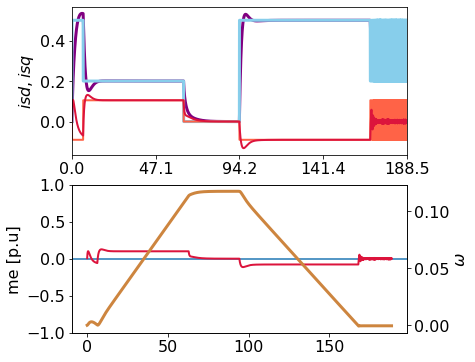

In [22]:
# a = 0.045
Tta, w, me, isd, isq, isdref, isqref = simulateSpeedingUpWithAcceleration()

# print(w)
plotDynamicForSpeedingUp(Tta, w, me, isd, isq, isdref, isqref)

In [16]:
def calculateIsdIsqRefs(ml, a, isq):
    rs,ld,lq, tmech, psirm = mach_para(mach_mc)
    isqOrig = isq
    while((psi_rm+(ld-lq)*isq) == 0 and isq >= -1 and isq <= 1):
        isq -= 0.001
    if((psi_rm+(ld-lq)*isq) != 0):
        isd = tmech*(a+ml)/(psi_rm+(ld-lq)*isq)
    else:
        isq = isqOrig
        while((psi_rm+(ld-lq)*isq) == 0 and isq >= -1 and isq <= 1):
            isq += 0.001
        if((psi_rm+(ld-lq)*isq) != 0):
            isd = tmech*(a+ml)/(psi_rm+(ld-lq)*isq)
    if((psi_rm+(ld-lq)*isq) == 0):
        isd, isq = -2, -2 # No solotion
    return isd, isq